# 2. Data Understanding: Auditoría y Transformación Inicial

## Justificación Metodológica
Esta fase implementa la limpieza y transformación de los datos crudos de las encuestas (cohortes Julio y Diciembre) bajo los principios de **Analítica de Supervivencia** sugeridos por la literatura reciente (Benhamed, 2025; Andonovikj et al., 2023).

### 1. Unificación Semántica (Matriz S_7)
Dado que las encuestas presentan variaciones en las preguntas de Soft Skills, se aplica un **mapeo semántico** para homogeneizar las dimensiones en 7 variables latentes ($S\_$). Esto garantiza que el modelo aprenda de conceptos consistentes (ej. *Ética Profesional*) y no de etiquetas específicas de una cohorte.

### 2. Tratamiento de la Variable Objetivo ($T$) y Censura
A diferencia de los modelos de clasificación binaria (Empleo Sí/No), modelar el **tiempo de inserción** permite mitigar el sesgo de supervivencia.
Siguiendo a **Benhamed (2025)**, tratamos a los graduados que siguen buscando empleo no como "casos perdidos", sino como datos **censurados a la derecha**.
* **$T=0$ (Inserción Concurrente):** Graduados que obtuvieron empleo antes de titularse o tienen antigüedades altas (> 6 meses al momento de la encuesta).
* **$T=3$ (Inserción Temprana):** Punto medio ("midpoint") para el intervalo "Menos de 6 meses", una aproximación válida en regresión cuando no se tiene el día exacto (Andonovikj et al., 2023).
* **$T=7$ (Censura):** Individuos que reportan "No trabajar" y estar buscando. Se asigna un valor superior a la ventana de observación (6 meses) para indicar que el evento de empleo aún no ocurre.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# 1. Carga de Datos (Asegúrate que las rutas sean correctas en tu PC)
try:
    # Intenta leer como Excel primero si son .xlsx reales, o CSV si son convertidos
    # Ajusta '../ENCUESTAS/' según tu carpeta real
    df_julio = pd.read_excel('../ENCUESTAS/Julio.xlsx')
    df_diciembre = pd.read_excel('../ENCUESTAS/Diembre.xlsx')
    print("✅ Archivos cargados correctamente.")
except Exception as e:
    print(f"❌ Error cargando archivos: {e}")

# 2. Auditoría de Columnas (Para no adivinar nombres)
print("\n--- COLUMNAS JULIO (Primeras 5 y Bloque de Soft Skills) ---")
print(df_julio.columns[:5].tolist())
# Buscamos columnas que contengan 'evalúa' para ver las skills
print([c for c in df_julio.columns if 'evalúa' in c.lower()][:3])

print("\n--- COLUMNAS DICIEMBRE (Primeras 5 y Bloque de Soft Skills) ---")
print(df_diciembre.columns[:5].tolist())
print([c for c in df_diciembre.columns if 'evalúa' in c.lower()][:3])

✅ Archivos cargados correctamente.

--- COLUMNAS JULIO (Primeras 5 y Bloque de Soft Skills) ---
['1.1 Edad:', '1.2 Género:', '3. Evaluación de Habilidades Blandas', 'A continuación, por favor evalúa qué tan bien consideras que desarrollaste las siguientes habilidades blandas durante tu formación en la EPN. Usa una escala de 1 a 5, donde 1 = Nada desarrollado y 5 = Totalmente desarrollado. [Gestión: Gestionar actividades complejas, como proyectos de ingeniería, en el campo de estudio.]', 'A continuación, por favor evalúa qué tan bien consideras que desarrollaste las siguientes habilidades blandas durante tu formación en la EPN. Usa una escala de 1 a 5, donde 1 = Nada desarrollado y 5 = Totalmente desarrollado. [Comunicación efectiva: Presentar y defender proyectos técnicos en español e inglés en entornos profesionales.]']
['A continuación, por favor evalúa qué tan bien consideras que desarrollaste las siguientes habilidades blandas durante tu formación en la EPN. Usa una escala de 1 a 5

Para garantizar que el modelo **XGBoost** aprenda de conceptos consistentes, se aplica el siguiente mapeo basado en el análisis de los textos de las preguntas:

| Variable Unificada | Justificación de la Unificación Semántica | Origen JULIO | Origen DICIEMBRE |
| --- | --- | --- | --- |
| **S_Comunicacion_ESP** | Capacidad de expresión clara y coherente en lengua materna. | [Comunicación efectiva] | [Com. eficaz en español] |
| **S_Comunicacion_ING** | Capacidad de comunicación técnica en lengua extranjera. | [Comunicación efectiva]* | [Com. eficaz en inglés] |
| **S_Etica_Profesional** | Actuar con honestidad, responsabilidad y respeto al marco normativo. | [Ética profesional] | [Compromiso ético] |
| **S_Liderazgo_Equipo** | Capacidad de colaboración, negociación y dirección de grupos. | Promedio([Liderazgo] + [Equipo]) | [Trabajo equipo y liderazgo] |
| **S_Responsabilidad_Soc** | Comprensión del impacto social, ambiental y sostenible. | [Responsabilidad social] | [Resp. social y sostenib.] |
| **S_Gestion_Proyectos** | Planificación, organización y administración de recursos técnicos. | [Gestión] | [Gestión de proyectos] |
| **S_Aprendizaje_Dig** | Búsqueda activa de conocimiento y uso de tecnologías. | [Aprendizaje autónomo] | [Hab. digitales y aprendizaje] |

**Nota: En la encuesta de Julio el inglés estaba integrado en la nota general de Comunicación. Para el modelo, se utiliza la misma puntuación en ambas dimensiones de comunicación para esa cohorte.*

In [2]:
# --- PASO 2: UNIFICACIÓN SEMÁNTICA (MATRIZ S_7) ---

# 1. Función de limpieza robusta (Likert 1-5)
def clean_likert(val):
    """Extrae el número de respuestas tipo '5 (Totalmente...)'"""
    if pd.isna(val): return np.nan
    import re
    # Busca el primer dígito en el texto
    match = re.search(r'\d+', str(val))
    if match:
        return float(match.group())
    return np.nan

# 2. Buscador de columnas por palabras clave (Para no fallar por tildes o espacios)
def find_col(df, keywords):
    """Retorna el nombre real de la columna que contiene TODAS las keywords."""
    if isinstance(keywords, str): keywords = [keywords]
    for col in df.columns:
        # Verifica si todas las palabras clave están en el nombre de la columna (ignorando mayúsculas)
        if all(k.lower() in col.lower() for k in keywords):
            return col
    return None

# --- PROCESAMIENTO JULIO ---
print("--- Procesando Cohorte JULIO ---")
df_j_clean = df_julio.copy()

# A. Mapeos Directos Julio
# Diccionario: {Nueva_Variable: [Palabras_Clave_en_Columna_Original]}
map_julio_direct = {
    'S_Etica_Profesional':   ['ética', 'profesional'],
    'S_Responsabilidad_Soc': ['responsabilidad', 'social'],
    'S_Gestion_Proyectos':   ['gestión', 'actividades'], # 'Gestión:' es distintivo
    'S_Aprendizaje_Dig':     ['aprendizaje', 'autónomo']
}

for var, kw in map_julio_direct.items():
    col_real = find_col(df_j_clean, kw)
    if col_real:
        df_j_clean[var] = df_j_clean[col_real].apply(clean_likert)
        print(f"✅ {var} <- {col_real[:30]}...")
    else:
        print(f"⚠️ NO ENCONTRADA: {var}")

# B. Reglas Especiales Julio
# 1. Comunicación (Se duplica porque en Julio evaluaron general)
col_com = find_col(df_j_clean, ['comunicación', 'efectiva'])
if col_com:
    val_com = df_j_clean[col_com].apply(clean_likert)
    df_j_clean['S_Comunicacion_ESP'] = val_com
    df_j_clean['S_Comunicacion_ING'] = val_com # DUPLICACIÓN
    print(f"✅ S_Comunicacion (ESP & ING) <- {col_com[:30]}...")

# 2. Liderazgo (Promedio Liderazgo + Trabajo en Equipo)
col_lid = find_col(df_j_clean, ['liderazgo'])
col_team = find_col(df_j_clean, ['trabajo', 'equipo'])

if col_lid and col_team:
    v_lid = df_j_clean[col_lid].apply(clean_likert)
    v_team = df_j_clean[col_team].apply(clean_likert)
    df_j_clean['S_Liderazgo_Equipo'] = (v_lid + v_team) / 2
    print(f"✅ S_Liderazgo_Equipo <- Promedio({col_lid[:15]}... + {col_team[:15]}...)")


# --- PROCESAMIENTO DICIEMBRE ---
print("\n--- Procesando Cohorte DICIEMBRE ---")
df_d_clean = df_diciembre.copy()

# A. Mapeos Directos Diciembre
map_dic_direct = {
    'S_Comunicacion_ESP':    ['eficaz', 'español'],
    'S_Comunicacion_ING':    ['eficaz', 'inglés'],
    'S_Etica_Profesional':   ['compromiso', 'ético'],
    'S_Responsabilidad_Soc': ['social', 'sostenib'],
    'S_Gestion_Proyectos':   ['gestión', 'proyectos'],
    'S_Aprendizaje_Dig':     ['digitales', 'aprendizaje'],
    'S_Liderazgo_Equipo':    ['trabajo', 'equipo', 'liderazgo'] # Columna combinada
}

for var, kw in map_dic_direct.items():
    col_real = find_col(df_d_clean, kw)
    if col_real:
        df_d_clean[var] = df_d_clean[col_real].apply(clean_likert)
        print(f"✅ {var} <- {col_real[:30]}...")
    else:
        print(f"⚠️ NO ENCONTRADA: {var}")

# Añadir etiquetas de cohorte
df_j_clean['Cohorte'] = 'Julio'
df_d_clean['Cohorte'] = 'Diciembre'

# Verificación de Nulos en las nuevas variables S_
cols_s = [c for c in df_d_clean.columns if c.startswith('S_')]
print("\n--- Verificación de Nulos (Variables S_) ---")
print("Julio Nulos:\n", df_j_clean[cols_s].isnull().sum())
print("Diciembre Nulos:\n", df_d_clean[cols_s].isnull().sum())

--- Procesando Cohorte JULIO ---
✅ S_Etica_Profesional <- A continuación, por favor eval...
✅ S_Responsabilidad_Soc <- A continuación, por favor eval...
✅ S_Gestion_Proyectos <- A continuación, por favor eval...
✅ S_Aprendizaje_Dig <- A continuación, por favor eval...
✅ S_Comunicacion (ESP & ING) <- A continuación, por favor eval...
✅ S_Liderazgo_Equipo <- Promedio(A continuación,... + A continuación,...)

--- Procesando Cohorte DICIEMBRE ---
✅ S_Comunicacion_ESP <- A continuación, por favor eval...
✅ S_Comunicacion_ING <- A continuación, por favor eval...
✅ S_Etica_Profesional <- A continuación, por favor eval...
✅ S_Responsabilidad_Soc <- A continuación, por favor eval...
✅ S_Gestion_Proyectos <- A continuación, por favor eval...
✅ S_Aprendizaje_Dig <- A continuación, por favor eval...
✅ S_Liderazgo_Equipo <- A continuación, por favor eval...

--- Verificación de Nulos (Variables S_) ---
Julio Nulos:
 S_Comunicacion_ESP       0
S_Comunicacion_ING       0
S_Etica_Profesional      0
S_

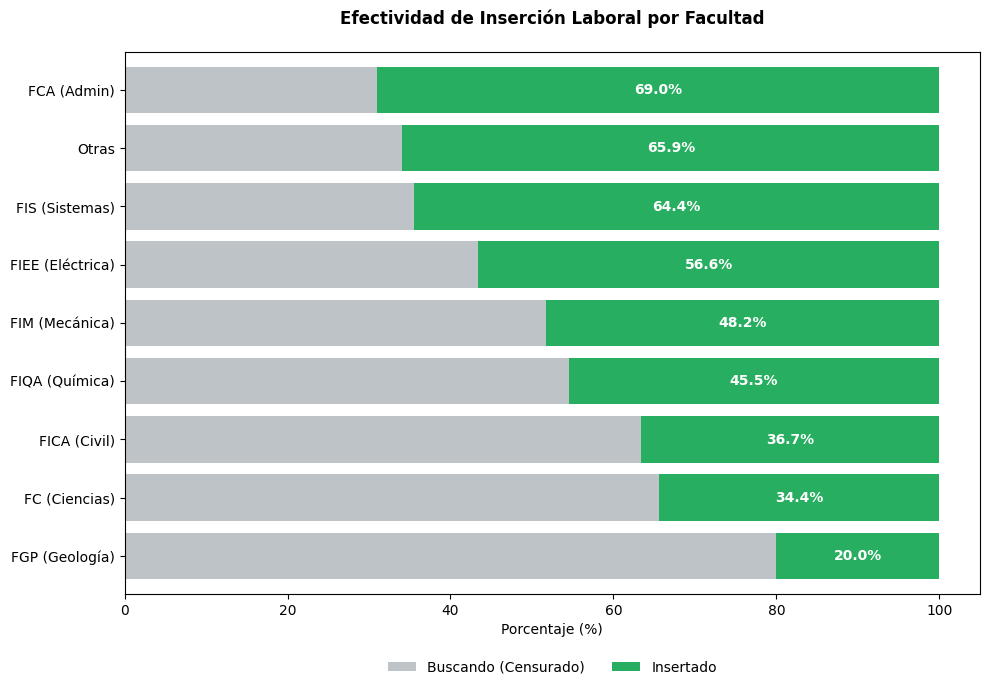

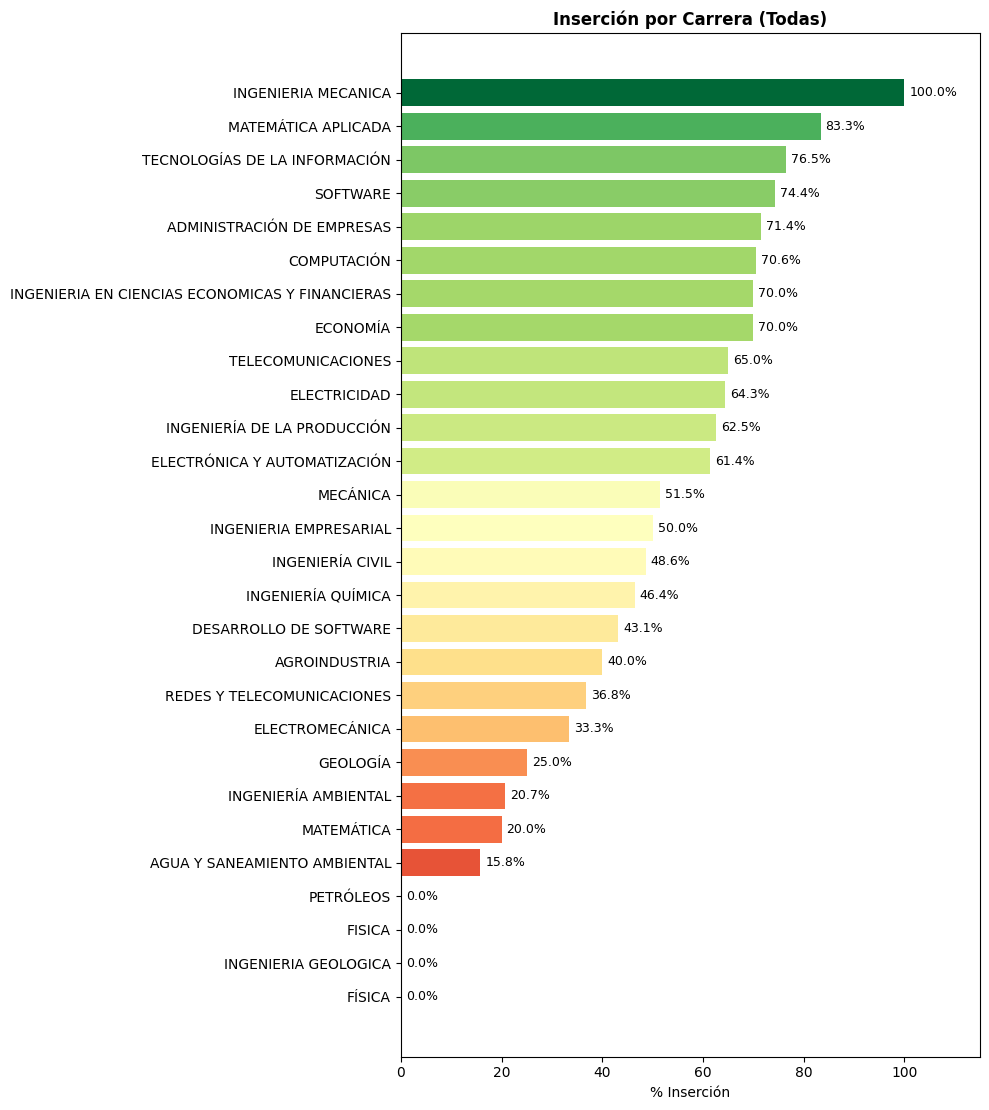

In [4]:
# --- PASO 5: VISUALIZACIÓN ROBUSTA ---
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata

# 1. FUNCIÓN DE NORMALIZACIÓN (Clave para arreglar Mecánica)
def normalize_text(text):
    """Elimina tildes y pone mayúsculas: 'Mecánica' -> 'MECANICA'"""
    if pd.isna(text): return "DESCONOCIDO"
    text = str(text).upper()
    return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

# 2. MAPEO DE FACULTADES (Usando texto normalizado)
def map_faculty_robust(c):
    c_clean = normalize_text(c).replace('(RRA20)', '').strip()
    
    if any(x in c_clean for x in ['SOFTWARE', 'COMPUTACION', 'SISTEMAS']): return 'FIS (Sistemas)'
    if any(x in c_clean for x in ['ELECTRICA', 'ELECTRONICA', 'TELECOM', 'REDES', 'AUTOMATIZACION']): return 'FIEE (Eléctrica)'
    if any(x in c_clean for x in ['CIVIL', 'AMBIENTAL', 'SANEAMIENTO']): return 'FICA (Civil)'
    if any(x in c_clean for x in ['MECANICA', 'ELECTROMECANICA']): return 'FIM (Mecánica)' # ¡AHORA SÍ ENTRA!
    if any(x in c_clean for x in ['GEOLOGIA', 'PETROLEOS']): return 'FGP (Geología)'
    if any(x in c_clean for x in ['QUIMICA', 'AGROINDUSTRIA']): return 'FIQA (Química)'
    if any(x in c_clean for x in ['ADMINISTRACION', 'ECONOMIA', 'EMPRESARIAL']): return 'FCA (Admin)'
    if any(x in c_clean for x in ['MATEMATICA', 'FISICA']): return 'FC (Ciencias)'
    return 'Otras'

df_final['Facultad_EPN'] = df_final['Carrera_Raw'].apply(map_faculty_robust)
df_final['Carrera_Clean'] = df_final['Carrera_Raw'].astype(str).str.replace(r'\(RRA20\)', '', regex=True).str.strip()

# --- GRÁFICO 1: EFECTIVIDAD POR FACULTAD (Leyenda Arreglada) ---
ct_fac = pd.crosstab(df_final['Facultad_EPN'], df_final['Evento'], normalize='index') * 100
ct_fac = ct_fac.sort_values(1, ascending=True)

fig, ax = plt.subplots(figsize=(10, 7))
ct_fac.plot(kind='barh', stacked=True, color=['#bdc3c7', '#27ae60'], width=0.8, ax=ax)

ax.set_title('Efectividad de Inserción Laboral por Facultad', fontweight='bold', pad=20)
ax.set_xlabel('Porcentaje (%)')
ax.set_ylabel('')

# Leyenda FUERA del gráfico para no tapar nada
ax.legend(['Buscando (Censurado)', 'Insertado'], 
          loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False)

# Etiquetas
for n, x in enumerate(ct_fac.index):
    val = ct_fac.loc[x, 1]
    if val > 5:
        ax.text((100-val) + val/2, n, f"{val:.1f}%", va='center', ha='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

# --- GRÁFICO 2: EFECTIVIDAD POR CARRERA (Sin Filtros) ---
tasas = df_final.groupby('Carrera_Clean')['Evento'].mean() * 100
tasas = tasas.sort_values()

fig, ax = plt.subplots(figsize=(10, max(8, len(tasas)*0.4)))
colors = plt.cm.RdYlGn(tasas.values / 100)
bars = ax.barh(tasas.index, tasas.values, color=colors)

ax.set_title('Inserción por Carrera (Todas)', fontweight='bold')
ax.set_xlabel('% Inserción')
ax.set_xlim(0, 115) # Espacio extra derecha

for rect in bars:
    width = rect.get_width()
    ax.text(width + 1, rect.get_y() + rect.get_height()/2, f'{width:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [5]:
# --- PASO 3: UNIFICACIÓN ROBUSTA (Busca Carreras por Contenido '(RRA20)') ---

def find_career_column_by_content(df):
    """
    Busca la columna que contiene códigos de carrera tipo '(RRA20)'
    en sus primeros valores. Es infalible contra nombres de columna ambiguos.
    """
    for col in df.columns:
        # Tomamos una muestra no nula
        sample = df[col].dropna().astype(str).head(50)
        # Verificamos si aparece el patrón EPN
        if sample.str.contains(r'\(RRA20\)', regex=True).any():
            return col
    # Fallback: Si no hay RRA20, busca la columna exacta "carrera" (ignorando mayúsculas)
    for col in df.columns:
        if col.strip().lower() == 'carrera':
            return col
    return None

# --- RE-EJECUCIÓN DEL PASO 3: UNIFICACIÓN CON TEXTO ---

def get_labor_data_v3(df, source_name):
    data = pd.DataFrame()
    data['Cohorte'] = source_name
    
    # 1. Identificadores y Laboral (Igual que antes)
    col_carrera = find_career_column_by_content(df)
    data['Carrera_Raw'] = df[col_carrera] if col_carrera else "DESCONOCIDO"

    col_trabaja = find_col(df, ['actualmente', 'trabajando'])
    data['Trabaja_Status'] = df[col_trabaja]

    col_antiguedad = find_col(df, ['tiempo', 'lleva', 'trabajando'])
    data['Antiguedad_Raw'] = df[col_antiguedad]

    col_salario = find_col(df, ['rango', 'salarial'])
    data['Salario_Raw'] = df[col_salario]
    
    col_practicas = find_col(df, ['prácticas', 'contribuido'])
    data['Practicas_Raw'] = df[col_practicas]

    # 2. Soft Skills (Heredadas)
    s_cols = [c for c in df.columns if c.startswith('S_')]
    for c in s_cols:
        data[c] = df[c]
        
    # --- 3. AQUÍ ESTÁ EL CAMBIO: EXTRAER TEXTO ABIERTO ---
    
    # A. Fortalezas (Asignaturas Relevantes)
    col_fortalezas = find_col(df, ['asignaturas', 'relevantes'])
    data['Texto_Fortalezas'] = df[col_fortalezas] if col_fortalezas else ""
    
    # B. Brechas/Gaps (Temas que debieron incluirse)
    # Buscamos por palabras clave como "temas", "debieron", "incluirse"
    col_brechas = find_col(df, ['temas', 'debieron'])
    if not col_brechas: 
        col_brechas = find_col(df, ['temas', 'incluirse'])
    
    data['Texto_Brechas'] = df[col_brechas] if col_brechas else ""
    
    return data

# Regenerar el DataFrame Maestro
print("--- Regenerando df_final con Textos ---")
df_j_lab = get_labor_data_v3(df_j_clean, 'Julio')
df_d_lab = get_labor_data_v3(df_d_clean, 'Diciembre')

df_final = pd.concat([df_j_lab, df_d_lab], ignore_index=True)

# Re-aplicar ingeniería de Target (se pierde al regenerar)
def engineer_target(row):
    status = str(row['Trabaja_Status']).strip().lower()
    is_working = status in ['si', 'sí', 'yes']
    tenure = str(row['Antiguedad_Raw']).strip().lower()
    if is_working:
        if any(x in tenure for x in ['más de 6 meses', 'entre 6 meses y 1 año', '1 a 2 años', 'más de 1 año', 'más de 2 años']):
            return 0, 1
        else:
            return 3, 1
    else:
        return 7, 0

outputs = df_final.apply(engineer_target, axis=1, result_type='expand')
df_final['T'] = outputs[0]
df_final['Evento'] = outputs[1]

# Volver a mapear facultades y limpiar carreras (necesario para gráficos)
df_final['Facultad_EPN'] = df_final['Carrera_Raw'].apply(map_faculty_robust)
df_final['Carrera_Clean'] = df_final['Carrera_Raw'].astype(str).str.replace(r'\(RRA20\)', '', regex=True).str.strip()

print(f"✅ df_final actualizado. Columnas de texto: 'Texto_Fortalezas', 'Texto_Brechas'")

--- Regenerando df_final con Textos ---
✅ df_final actualizado. Columnas de texto: 'Texto_Fortalezas', 'Texto_Brechas'


In [6]:
# --- PASO 4: INGENIERÍA DE TARGET (RE-EJECUCIÓN) ---

def engineer_target(row):
    status = str(row['Trabaja_Status']).strip().lower()
    is_working = status in ['si', 'sí', 'yes']
    tenure = str(row['Antiguedad_Raw']).strip().lower()
    
    if is_working:
        # Inserción Previa/Concurrente (> 6 meses)
        if any(x in tenure for x in ['más de 6 meses', 'entre 6 meses y 1 año', '1 a 2 años', 'más de 1 año']):
            return 0, 1
        # Inserción Reciente (< 6 meses)
        else:
            return 3, 1
    else:
        # Censurado
        return 7, 0

out = df_final.apply(engineer_target, axis=1, result_type='expand')
df_final['T'] = out[0]
df_final['Evento'] = out[1]

print("✅ Target generado.")
print(df_final['T'].value_counts())

✅ Target generado.
T
7    310
3    273
0     82
Name: count, dtype: int64


### 3.3. Antigüedad y Tiempos de Inserción
**Objetivo:** Analizar la temporalidad de la inserción laboral.
**Justificación:** Diferenciar entre inserción "previa/concurrente" (Early Birds) e inserción "posterior" es crucial. Según la literatura, los estudiantes que se vinculan laboralmente antes de graduarse suelen tener mejores trayectorias salariales iniciales.

/tmp/ipykernel_157537/972805314.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


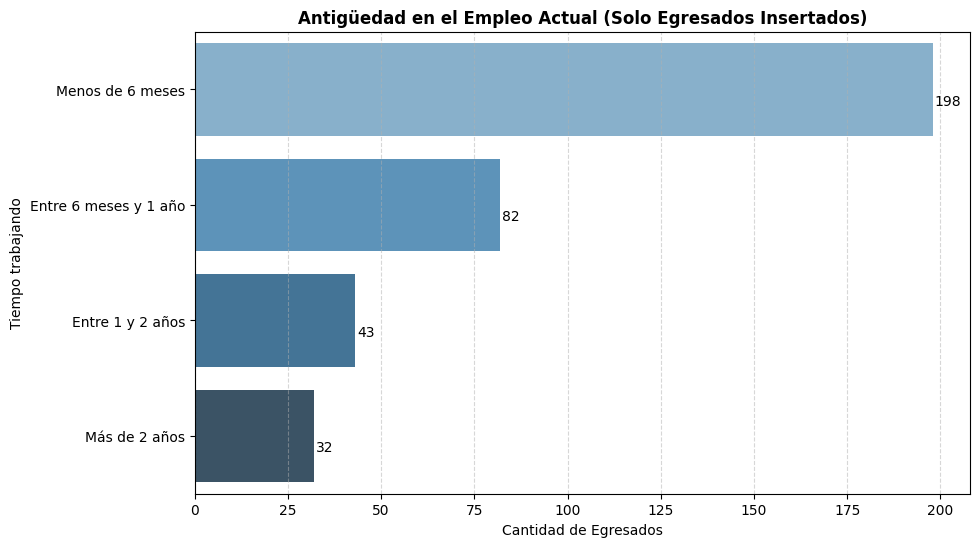

In [7]:
# Configuración del orden lógico de las categorías
orden_antiguedad = [
    'Menos de 6 meses', 
    'Entre 6 meses y 1 año', 
    'Entre 1 y 2 años', 
    'Más de 1 año', # A veces aparece esta variante
    'Más de 2 años'
]

# Filtrar solo los insertados (Evento = 1)
df_trabajan = df_final[df_final['Evento'] == 1]

plt.figure(figsize=(10, 6))
sns.countplot(
    y='Antiguedad_Raw', 
    data=df_trabajan, 
    order=[x for x in orden_antiguedad if x in df_trabajan['Antiguedad_Raw'].unique()],
    palette='Blues_d'
)

plt.title('Antigüedad en el Empleo Actual (Solo Egresados Insertados)', fontweight='bold')
plt.xlabel('Cantidad de Egresados')
plt.ylabel('Tiempo trabajando')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Etiquetas de valor
ax = plt.gca()
for p in ax.patches:
    if p.get_width() > 0:
        ax.annotate(f'{int(p.get_width())}', 
                    (p.get_width() + 0.5, p.get_y() + 0.5), va='center')

plt.show()

### 3.4. Distribución Salarial Inicial
**Objetivo:** Caracterizar el retorno económico inmediato de los egresados.
**Insight Esperado:** Identificar la moda salarial (el rango más común) y detectar si existen carreras o facultades que rompen la tendencia del "salario básico de entrada".

/tmp/ipykernel_157537/1698727291.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


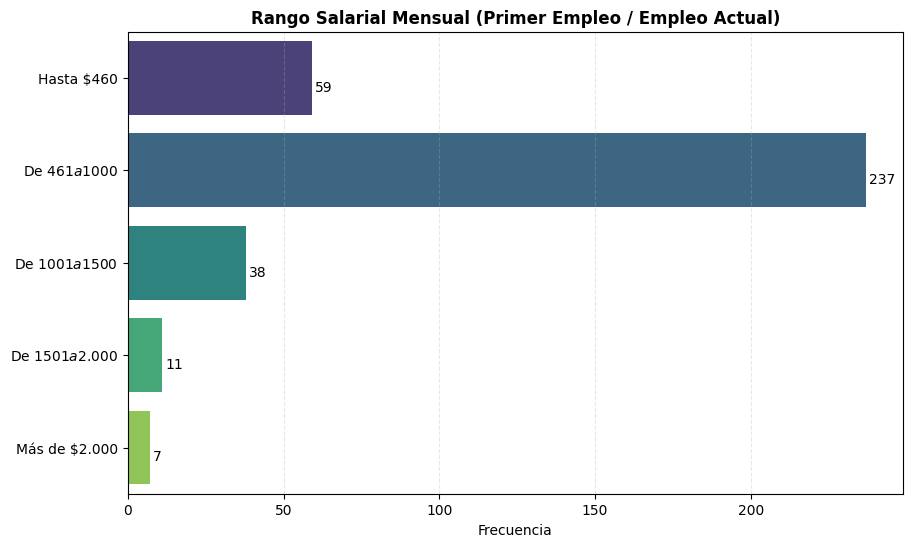

In [8]:
# Orden lógico de salarios
orden_salario = [
    'Hasta $460', 
    'De $461 a $1000', 
    'De $1001 a $1500', 
    'De $1501 a $2.000', 
    'Más de $2.000'
]

plt.figure(figsize=(10, 6))
sns.countplot(
    y='Salario_Raw', 
    data=df_trabajan, # Usamos el df filtrado de los que trabajan
    order=[x for x in orden_salario if x in df_trabajan['Salario_Raw'].unique()],
    palette='viridis'
)

plt.title('Rango Salarial Mensual (Primer Empleo / Empleo Actual)', fontweight='bold')
plt.xlabel('Frecuencia')
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Etiquetas
ax = plt.gca()
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(f'{int(width)}', (width + 1, p.get_y() + 0.5), va='center')

plt.show()

### 3.5. Percepción de Utilidad de las Prácticas Preprofesionales
**Pregunta de Investigación:** ¿Perciben los egresados que sus pasantías aportaron valor real a su desempeño profesional actual?
**Relevancia:** Validar si la vinculación temprana universidad-empresa es un factor de calidad en la formación.

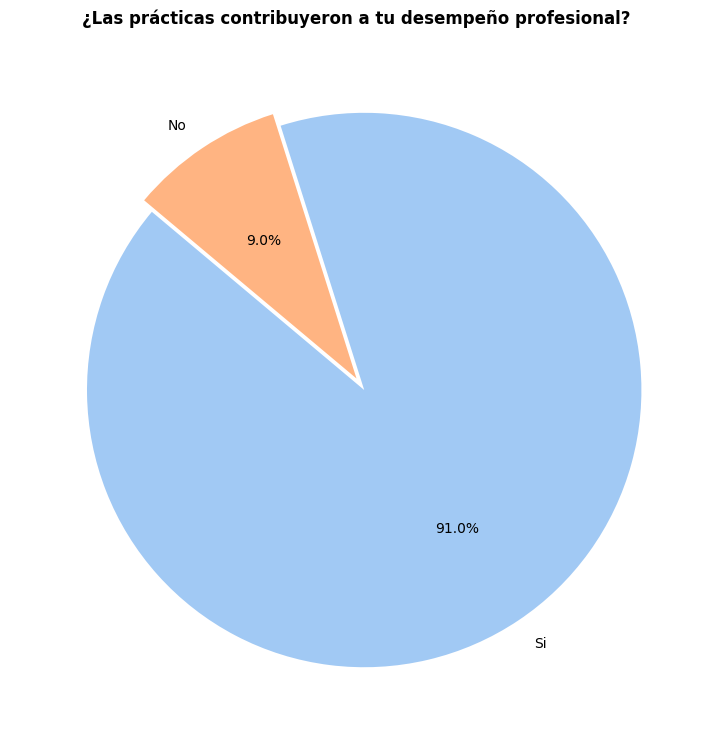

In [9]:
# Contar valores, ignorando nulos
conteo_practicas = df_final['Practicas_Raw'].value_counts()

plt.figure(figsize=(9, 9))
plt.pie(
    conteo_practicas, 
    labels=conteo_practicas.index, 
    autopct='%1.1f%%', 
    startangle=140,
    colors=sns.color_palette('pastel'),
    explode=[0.05 if i == 0 else 0 for i in range(len(conteo_practicas))] # Destacar el más común
)

plt.title('¿Las prácticas contribuyeron a tu desempeño profesional?', fontweight='bold')
plt.show()

### 3.6. Perfil de Habilidades Blandas (Autoevaluación)
**Objetivo:** Visualizar la distribución de las competencias transversales ($S\_Variables$) unificadas.
**Análisis:** Utilizando diagramas de caja (boxplots), podemos observar no solo la mediana, sino la dispersión. Una baja dispersión con medianas altas (efecto techo) podría indicar un sesgo de autoevaluación positivo común en encuestas de egresados.

/tmp/ipykernel_157537/1738377702.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Puntuación (1-5)', y='Habilidad', data=df_melted, palette='Set3')


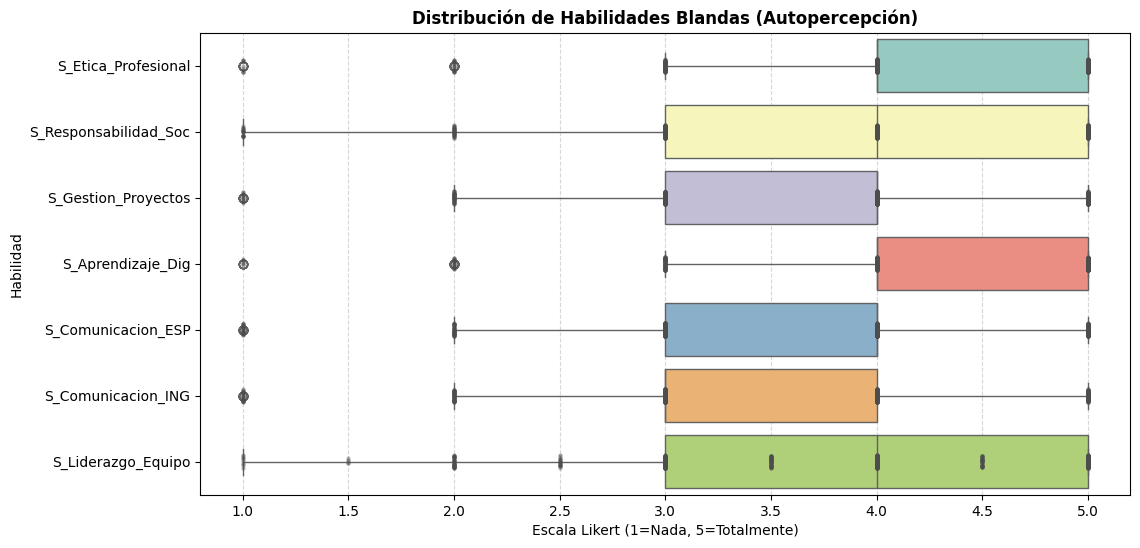

In [10]:
# Seleccionar solo las columnas S_
cols_soft = [c for c in df_final.columns if c.startswith('S_')]

# Convertir a formato largo para poder graficar con Seaborn
df_melted = df_final[cols_soft].melt(var_name='Habilidad', value_name='Puntuación (1-5)')

plt.figure(figsize=(12, 6))
sns.boxplot(x='Puntuación (1-5)', y='Habilidad', data=df_melted, palette='Set3')
sns.stripplot(x='Puntuación (1-5)', y='Habilidad', data=df_melted, size=3, color=".3", alpha=0.4) # Puntos reales

plt.title('Distribución de Habilidades Blandas (Autopercepción)', fontweight='bold')
plt.xlabel('Escala Likert (1=Nada, 5=Totalmente)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

### 3.7. Análisis de Supervivencia: Curva de Kaplan-Meier
**Metodología:** Estimación no paramétrica de la función de supervivencia $S(t)$.
**Interpretación:** Muestra la probabilidad de **seguir buscando empleo** a lo largo del tiempo.
* **Escalón en T=0:** Caída abrupta por inserción concurrente (graduados que ya trabajaban).
* **Escalón en T=3:** Inserción temprana post-graduación.
* **Meseta final:** Proporción de egresados que entran en riesgo de desempleo de larga duración (censura).

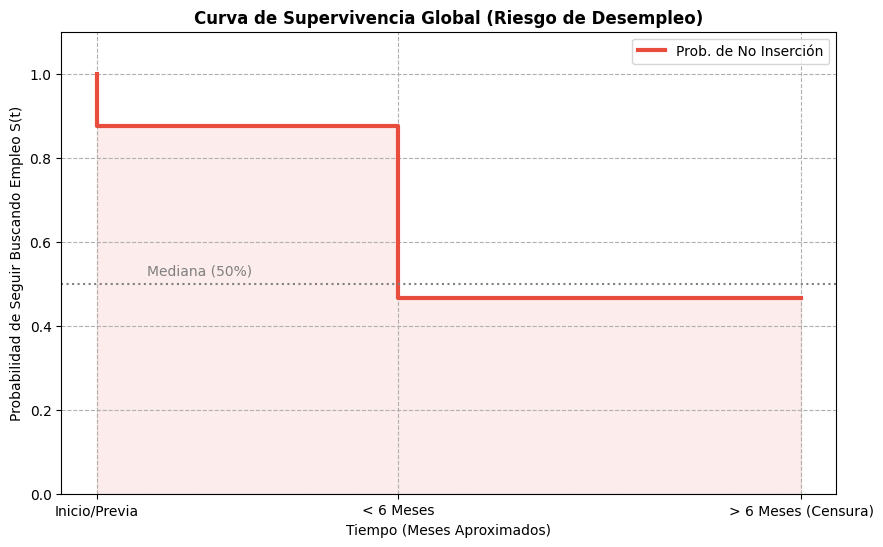

In [11]:
# Preparación de datos para KM
km_data = df_final.groupby('T')['Evento'].agg(['count', 'sum']).rename(columns={'count':'n_total', 'sum':'eventos'})

# Cálculo manual para visualización (preparación para librerías avanzadas en Fase 3)
tiempos = [0, 3, 7]
prob_supervivencia = [1.0] # En t=0 todos "vivos" antes del evento
riesgo_actual = len(df_final)
s_actual = 1.0

eje_t = [0] # Eje X para el gráfico

for t in tiempos:
    if t in km_data.index:
        ev = km_data.loc[t, 'eventos']
        total_grupo = km_data.loc[t, 'n_total'] # Gente en este bucket
        
        # Fórmula KM: S(t) = S(t-1) * (1 - d/n)
        if riesgo_actual > 0:
            s_actual = s_actual * (1 - (ev / riesgo_actual))
        
        prob_supervivencia.append(s_actual)
        eje_t.append(t)
        
        # Reducimos el set de riesgo (los qCalcula la Correlación de Spearman entre las 7 nuevas S_ y el tiempo $T$.ue ya tuvieron evento o se censuraron salen)
        riesgo_actual -= total_grupo

plt.figure(figsize=(10, 6))
plt.step(eje_t, prob_supervivencia, where='post', color='#e74c3c', linewidth=3, label='Prob. de No Inserción')
plt.fill_between(eje_t, prob_supervivencia, step='post', alpha=0.1, color='#e74c3c')

plt.title('Curva de Supervivencia Global (Riesgo de Desempleo)', fontweight='bold')
plt.ylabel('Probabilidad de Seguir Buscando Empleo S(t)')
plt.xlabel('Tiempo (Meses Aproximados)')
plt.ylim(0, 1.1)
plt.xticks([0, 3, 7], ['Inicio/Previa', '< 6 Meses', '> 6 Meses (Censura)'])
plt.grid(True, which='both', linestyle='--')

# Línea de mediana (50%)
plt.axhline(y=0.5, color='gray', linestyle=':')
plt.text(0.5, 0.52, 'Mediana (50%)', color='gray')

plt.legend()
plt.show()

### 3.8. Análisis de Texto: Habilidades Técnicas y Brechas Curriculares
**Metodología:** Tokenización y conteo de frecuencias de n-gramas.
**Pregunta 6.1 (Fortalezas):** *"¿Qué asignaturas te resultaron más relevantes?"* -> Identifica qué valora el mercado actual.
**Pregunta 6.2 (Brechas):** *"¿Qué temas consideras que debieron incluirse?"* -> Identifica la deuda curricular (Gap Analysis).
**Relevancia Prescriptiva:** Estos hallazgos se traducirán directamente en recomendaciones de actualización de malla curricular en la Fase 4.

/tmp/ipykernel_157537/290287058.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(counts), y=list(skills), palette='Blues_r', edgecolor='black', linewidth=0.8)


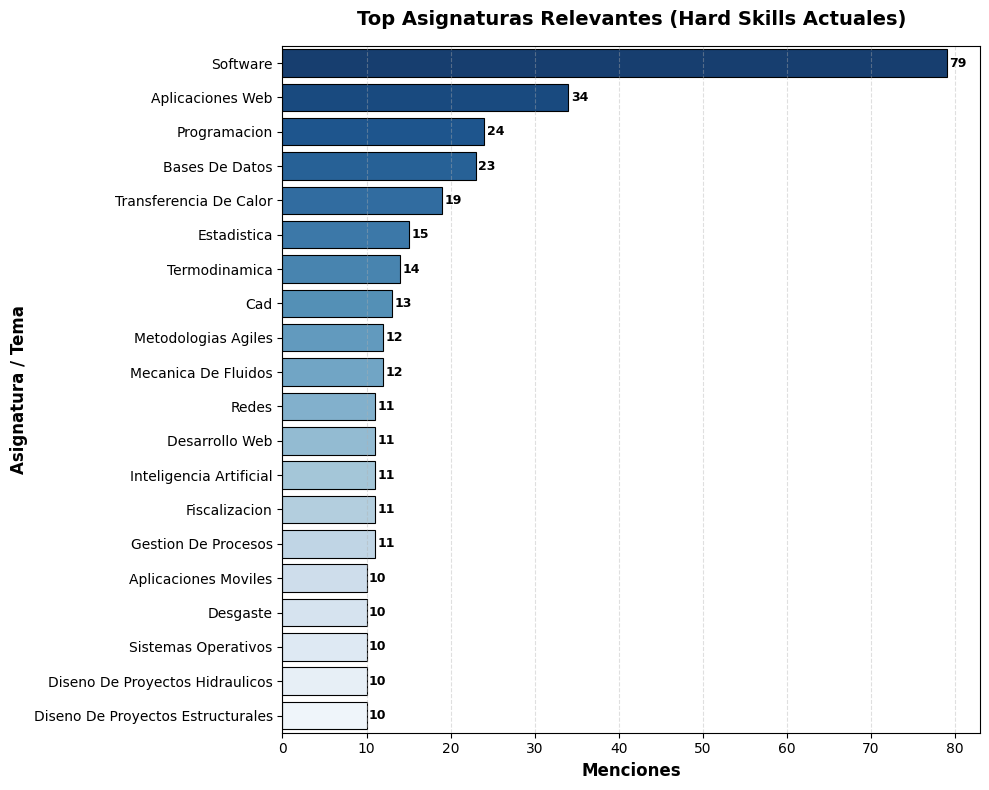

/tmp/ipykernel_157537/290287058.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(counts_g), y=list(gaps), palette='Reds_r', edgecolor='black', linewidth=0.8)


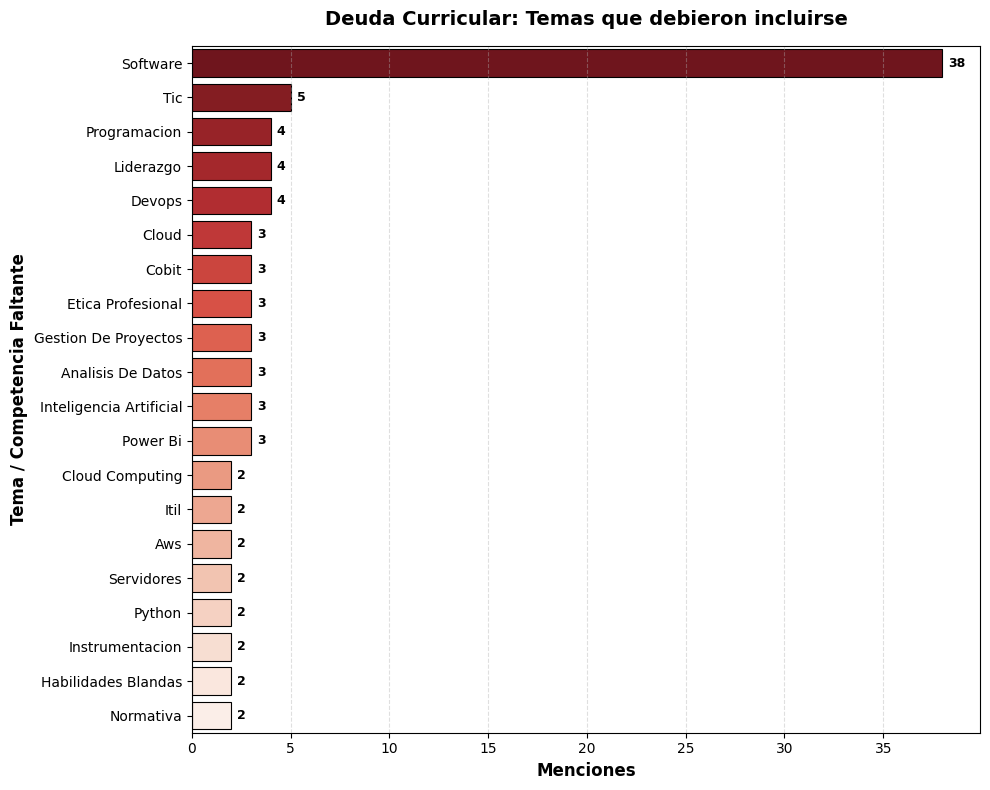


--- ANÁLISIS DE BRECHAS CURRICULARES ---
🔴 Lo que más piden los egresados: ['Software', 'Tic', 'Programacion', 'Liderazgo', 'Devops']
🔵 Fortalezas más mencionadas: ['Software', 'Aplicaciones Web', 'Programacion', 'Bases De Datos', 'Transferencia De Calor']


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import unicodedata
# 1. Función de Limpieza y Tokenización (Mejorada)
def process_text_column_direct(text_series, top_n=15):
    """Procesa una Serie de pandas con texto sucio y retorna los tokens más comunes."""
    
    # Unir todo el texto no nulo
    text_corpus = text_series.dropna().astype(str).tolist()
    all_text = ' '.join(text_corpus)
    
    # Normalización (Minusculas, quitar tildes)
    all_text = all_text.lower()
    all_text = ''.join(c for c in unicodedata.normalize('NFD', all_text) if unicodedata.category(c) != 'Mn')
    
    # Separar por delimitadores comunes en encuestas
    # Separa por: comas, puntos, guiones, saltos de línea, o la palabra " y "
    tokens = re.split(r'[,.;\-\n]|\s+y\s+', all_text)
    
    clean_tokens = []
    # Stopwords ampliadas para limpiar ruido académico
    stopwords = [
        'de', 'la', 'en', 'el', 'los', 'las', 'del', 'para', 'con', 'un', 'una', 
        'introduccion', 'fundamentos', 'ing', 'ingenieria', 'basica', 'general',
        'analisis', 'diseno', 'sistemas', 'aplicada', 'temas', 'sobre', 'como',
        'sus', 'que', 'mas', 'todo', 'uso', 'nan', 'null', 'parte', 'area', 'areas'
    ]
    
    for t in tokens:
        t = t.strip()
        # Filtrar basura
        if len(t) > 2 and t not in stopwords and not t.isdigit():
            # Unificar variaciones comunes (ej. "tics" -> "tic")
            if t == 'tics': t = 'tic'
            if 'software' in t: t = 'software' # Agrupar todo lo de software
            
            clean_tokens.append(t.title())
            
    return Counter(clean_tokens).most_common(top_n)
# --- GRÁFICO 1: FORTALEZAS (Texto_Fortalezas) ---
plt.figure(figsize=(10, 8))
if 'Texto_Fortalezas' in df_final.columns:
    top_fortalezas = process_text_column_direct(df_final['Texto_Fortalezas'], 20)
    
    if top_fortalezas:
        skills, counts = zip(*top_fortalezas)
        ax = sns.barplot(x=list(counts), y=list(skills), palette='Blues_r', edgecolor='black', linewidth=0.8)
        plt.title('Top Asignaturas Relevantes (Hard Skills Actuales)', fontweight='bold', fontsize=14, pad=15)
        plt.xlabel('Menciones', fontsize=12, fontweight='bold')
        plt.ylabel('Asignatura / Tema', fontsize=12, fontweight='bold')
        
        # Añadir valores en las barras
        for i, v in enumerate(counts):
            plt.text(v + 0.3, i, str(v), va='center', fontweight='bold', fontsize=9)
        
        plt.grid(axis='x', linestyle='--', alpha=0.4)
        plt.tight_layout()
    else:
        plt.text(0.5, 0.5, 'No hay datos de texto suficientes', ha='center', fontsize=12)
else:
    plt.text(0.5, 0.5, 'Columna Texto_Fortalezas no existe', ha='center', fontsize=12)
plt.show()
# --- GRÁFICO 2: BRECHAS / GAPS (Texto_Brechas) ---
plt.figure(figsize=(10, 8))
if 'Texto_Brechas' in df_final.columns:
    top_brechas = process_text_column_direct(df_final['Texto_Brechas'], 20)
    
    if top_brechas:
        gaps, counts_g = zip(*top_brechas)
        ax = sns.barplot(x=list(counts_g), y=list(gaps), palette='Reds_r', edgecolor='black', linewidth=0.8)
        plt.title('Deuda Curricular: Temas que debieron incluirse', fontweight='bold', fontsize=14, pad=15)
        plt.xlabel('Menciones', fontsize=12, fontweight='bold')
        plt.ylabel('Tema / Competencia Faltante', fontsize=12, fontweight='bold')
        
        # Añadir valores en las barras
        for i, v in enumerate(counts_g):
            plt.text(v + 0.3, i, str(v), va='center', fontweight='bold', fontsize=9)
        
        plt.grid(axis='x', linestyle='--', alpha=0.4)
        plt.tight_layout()
    else:
        plt.text(0.5, 0.5, 'No hay datos de texto suficientes', ha='center', fontsize=12)
else:
    plt.text(0.5, 0.5, 'Columna Texto_Brechas no existe', ha='center', fontsize=12)
plt.show()
# Imprimir resumen
print("\n" + "="*70)
print("--- ANÁLISIS DE BRECHAS CURRICULARES ---")
print("="*70)
if 'top_brechas' in locals() and top_brechas:
    print("🔴 Lo que más piden los egresados:", [x[0] for x in top_brechas[:5]])
if 'top_fortalezas' in locals() and top_fortalezas:
    print("🔵 Fortalezas más mencionadas:", [x[0] for x in top_fortalezas[:5]])
print("="*70)

### 3.9. Validación Estadística: Correlación de Spearman ($S\_$ vs $T$)
**Objetivo:** Determinar estadísticamente qué habilidades blandas están asociadas a una inserción laboral más rápida.
**Metodología:** Usamos el coeficiente de Spearman ($\rho$) porque nuestras variables son ordinales (Likert 1-5) y el tiempo ($T$) es discreto.
**Interpretación:**
* **Correlación Negativa ($\rho < 0$):** Indica que a *mayor* desarrollo de la habilidad, *menor* es el tiempo de búsqueda (Factor protector).
* **Magnitud:** Si $|\rho| > 0.1$, es un hallazgo relevante para ciencias sociales. Si es cercano a 0, sugiere que el mercado no está discriminando por esa habilidad o que hay un "efecto techo" (todos se ponen 5/5).

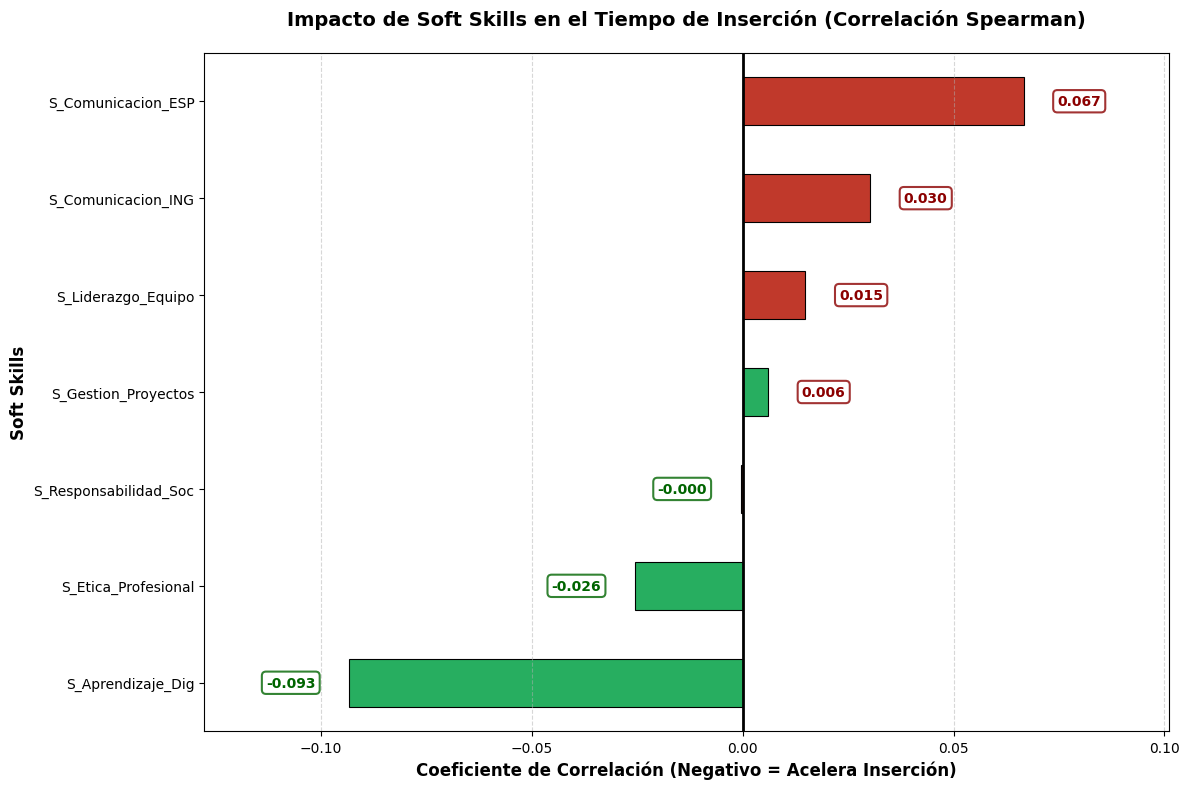


📊 INTERPRETACIÓN RÁPIDA:
🟢 Barras VERDES (izquierda): Habilidades que ACELERAN la inserción
🔴 Barras ROJAS (derecha): Habilidades que RETRASAN la inserción


In [17]:
# 1. Calcular la matriz de correlación
cols_soft = [c for c in df_final.columns if c.startswith('S_')]
# Añadimos T para ver la relación con el tiempo
corr_spearman = df_final[cols_soft + ['T']].corr(method='spearman')['T'].drop('T')
# 2. Visualización mejorada
plt.figure(figsize=(12, 8))  # Aumentamos el tamaño para mejor visualización
# Colores: Verde si ayuda a reducir tiempo (negativo), Rojo si lo aumenta (positivo)
colors = ['#27ae60' if x < 0 else '#c0392b' for x in corr_spearman.values]
# Ordenamos los valores
corr_sorted = corr_spearman.sort_values()
ax = corr_sorted.plot(kind='barh', color=colors, edgecolor='black', linewidth=0.8)
plt.title('Impacto de Soft Skills en el Tiempo de Inserción (Correlación Spearman)', 
          fontweight='bold', fontsize=14, pad=20)
plt.xlabel('Coeficiente de Correlación (Negativo = Acelera Inserción)', fontsize=12, fontweight='bold')
plt.ylabel('Soft Skills', fontsize=12, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=2)
plt.grid(axis='x', linestyle='--', alpha=0.5)
# Añadir valores en las barras - Mejorado para evitar solapamiento
for index, value in enumerate(corr_sorted):
    # Posicionamiento inteligente del texto
    if value >= 0:
        # Para valores positivos, texto a la derecha de la barra
        ha = 'left'
        offset = 0.008
        color_text = '#8B0000'  # Rojo oscuro
    else:
        # Para valores negativos, texto a la izquierda de la barra
        ha = 'right'
        offset = -0.008
        color_text = '#006400'  # Verde oscuro
    
    plt.text(value + offset, index, f'{value:.3f}', 
             va='center', ha=ha, fontweight='bold', fontsize=10,
             color=color_text, bbox=dict(boxstyle='round,pad=0.3', 
                                         facecolor='white', 
                                         edgecolor=color_text, 
                                         alpha=0.8, linewidth=1.5))
# Ajustar los límites del eje x para dar espacio a los textos
x_min, x_max = ax.get_xlim()
x_range = x_max - x_min
plt.xlim(x_min - x_range * 0.15, x_max + x_range * 0.15)
# Mejorar el estilo de las etiquetas del eje y
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()
print("\n" + "="*70)
print("📊 INTERPRETACIÓN RÁPIDA:")
print("="*70)
print("🟢 Barras VERDES (izquierda): Habilidades que ACELERAN la inserción")
print("🔴 Barras ROJAS (derecha): Habilidades que RETRASAN la inserción")
print("="*70)

### 3.10. Perfil Competencial: Comparativa Empleados vs. En Búsqueda
**Objetivo:** Visualizar si existe una "brecha de habilidades" autopercibida entre los egresados que ya consiguieron empleo y los que no.
**Herramienta:** Gráfico de Radar (Spider Plot).
**Hipótesis:** Se esperaría que el área del polígono de los "Insertados" sea mayor, cubriendo mejor dimensiones clave como *Comunicación* o *Gestión*. Si los polígonos son idénticos, el desempleo podría deberse a factores externos y no a falta de capacidades.

/tmp/ipykernel_157537/3937250412.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([1, 2, 3, 4, 5], color="grey", size=7)


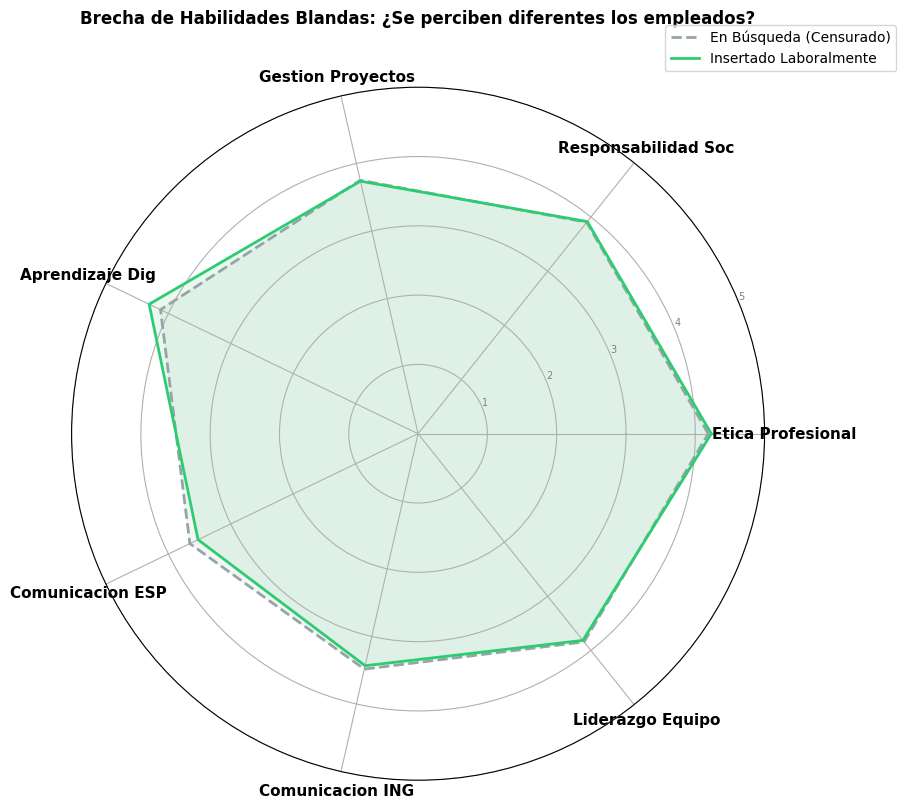

In [18]:
import numpy as np

# 1. Preparar datos promedio por grupo (Evento 0 vs 1)
df_radar = df_final.groupby('Evento')[cols_soft].mean()

# Etiquetas limpias (quitar 'S_') para el gráfico
labels = [c.replace('S_', '').replace('_', ' ') for c in cols_soft]
num_vars = len(labels)

# 2. Configuración de ángulos para el radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] # Cerrar el círculo

# 3. Datos para plotear (repetir el primer valor al final para cerrar)
# Grupo: En Búsqueda (Evento=0)
values_0 = df_radar.loc[0].tolist()
values_0 += values_0[:1]

# Grupo: Insertado (Evento=1)
values_1 = df_radar.loc[1].tolist()
values_1 += values_1[:1]

# 4. Generar Gráfico
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))

# Dibujar Grupo 0 (Buscando)
ax.plot(angles, values_0, color='#95a5a6', linewidth=2, linestyle='--', label='En Búsqueda (Censurado)')
ax.fill(angles, values_0, color='#95a5a6', alpha=0.1)

# Dibujar Grupo 1 (Insertado)
ax.plot(angles, values_1, color='#2ecc71', linewidth=2, label='Insertado Laboralmente')
ax.fill(angles, values_1, color='#2ecc71', alpha=0.1)

# Estética
ax.set_yticklabels([1, 2, 3, 4, 5], color="grey", size=7)
ax.set_ylim(0, 5) # Escala Likert fija
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, size=11, fontweight='bold')

plt.title('Brecha de Habilidades Blandas: ¿Se perciben diferentes los empleados?', y=1.08, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.show()

### 3.11. Calidad de Prácticas vs. Éxito de Inserción
**Objetivo:** Validar si una valoración positiva de las prácticas preprofesionales correlaciona con una mayor tasa de empleo actual.
**Análisis:** Cruzamos la percepción de utilidad (X) con la tasa de inserción (Color).